# Project 10

## Parte 1. Priorizar hipótesis

Para priorizar hipótesis, se han evaluado los siguientes factores de cada una: impacto, confianza, esfuerzo y alcance. Se aplicarán los frameworks ICE y RICE para priorizar las hipótesis.

ICE = (impact * confidence) / effort

RICE = (reach * impact * confidence) / effort

RICE = reach * ICE

In [1]:
#Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import datetime as dt

A continuación se muestran algunas hipótesis.

In [2]:
#Read csv file
data = pd.read_csv('./hypotheses_us.csv', sep=';', header=0)
data

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


### Framework ICE

In [3]:
#Obtain ICE value
data['ICE'] = (data['Impact']*data['Confidence']) / data['Effort']
print(data[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

                                          Hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


De manera que la hipótesis con más prioridad es "Launch a promotion that gives users discounts", después "Add two new channels for attracting traffic." y así sucesivamente. Ahora prioricemos mediante el framework RICE.

### Framework RICE

In [4]:
#Obtain RICE value
data['RICE'] = (data['Reach']*data['Impact']*data['Confidence']) / data['Effort']
print(data[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False))

                                          Hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


De manera que la hipótesis con más prioridad es "Add a subscription form to all the main pages", después "Add product recommendation blocks to the store." y así sucesivamente.

Se puede ver que las prioridades de las hipótesis cambiaron, ya que con este ultimo framwork, el factor alcance eleva o disminuye la prioridad, es decir, RICE = reach * ICE.

## Parte 2. Análisis del test A/B

Se analizarán los resultados de una prueba A/B realizada previamente. Se importan los DataFrames y se verifica si hay valores duplicados, respecto a las columnas 'date' y 'group'.

In [5]:
#Read DataFrame
orders = pd.read_csv('./orders_us.csv', sep=',', header=0)
#Change columns names
orders.columns = ['orderId','userId','date','revenue','group']
#Change column type
orders['date'] = pd.to_datetime(orders['date'])
orders['date'] = orders['date'].dt.strftime('%d/%m/%Y')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%d/%m/%Y'))
#Show DataFrame
orders.head(5)

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
#Read DataFrame
visits = pd.read_csv('./visits_us.csv', sep=',', header=0)
#Change columns names
visits.columns = ['date','group','visitors']
#Change column type
visits['date'] = pd.to_datetime(visits['date'])
visits['date'] = visits['date'].dt.strftime('%d/%m/%Y')
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%d/%m/%Y'))
#Show DataFrame
visits.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Para evitar el "peeking problem", se analizán gráficos de métricas acumuladas (el primer día están valores de las métricas para ese día, el segundo día están la suma de las métricas de los dos primeros días y así en adelante).

#### 1. Representa gráficamente el ingreso acumulado por grupo.

Se crea un DataFrame con valores únicos de parejas fecha-grupo.

In [7]:
#DataFrame with columns 'date' and 'group' (no duplicates)
datesGroups = orders[['date','group']].drop_duplicates()

Se obtienen las filas de la tabla orders donde la fecha es menor o igual que la fecha del elemento datesGroups y el grupo de prueba es el mismo que en datesGroups. Luego, agregaremos los valores y encontraremos la fecha máxima. También encontraremos el valor máximo para el grupo para tener la columna 'group' en la salida final. Encontramos el número de pedidos únicos e identificadores de usuarios y calculamos la suma de los tamaños de compra promedio.

Aplicaremos los métodos a cada fila del DataFrame (apply(axis=1)) y ordenaremos los resultados por las columnas 'date' y 'group'. Tras poner todo esto junto, se obtiene:

In [8]:
#Obtain metrics
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date' : 'max', 'group' : 'max', 'orderId' : pd.Series.nunique, 'userId' : pd.Series.nunique, 'revenue' : 'sum'
}), axis=1).sort_values(by=['date','group'])

print(ordersAggregated)

          date group  orderId  userId  revenue
55  2019-08-01     A       24      20   2356.8
66  2019-08-01     B       21      20   1620.0
175 2019-08-02     A       44      38   3860.3
173 2019-08-02     B       45      43   4243.8
291 2019-08-03     A       68      62   5675.5
..         ...   ...      ...     ...      ...
496 2019-08-29     B      596     544  87343.0
730 2019-08-30     A      545     493  63563.5
690 2019-08-30     B      620     567  90736.3
958 2019-08-31     A      557     503  64554.9
930 2019-08-31     B      640     586  92840.6

[62 rows x 5 columns]


Vamos a hacer algo parecido para obtener los datos diarios acumulados agregados sobre los visitantes

In [9]:
#Obtain metrics
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

print(visitorsAggregated)

          date group  visitors
55  2019-08-01     A       719
66  2019-08-01     B       713
175 2019-08-02     A      1338
173 2019-08-02     B      1294
291 2019-08-03     A      1845
..         ...   ...       ...
496 2019-08-29     B     17708
730 2019-08-30     A     18037
690 2019-08-30     B     18198
958 2019-08-31     A     18736
930 2019-08-31     B     18916

[62 rows x 3 columns]


Fusionamos las dos tablas en una y damos a sus columnas nombres descriptivos.

In [10]:
#Merge DataFrames
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
#Change column names
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   2356.8       719
1 2019-08-01     B      21      20   1620.0       713
2 2019-08-02     A      44      38   3860.3      1338
3 2019-08-02     B      45      43   4243.8      1294
4 2019-08-03     A      68      62   5675.5      1845


Creemos gráficos de ingresos acumulados por día y grupo de prueba A/B.

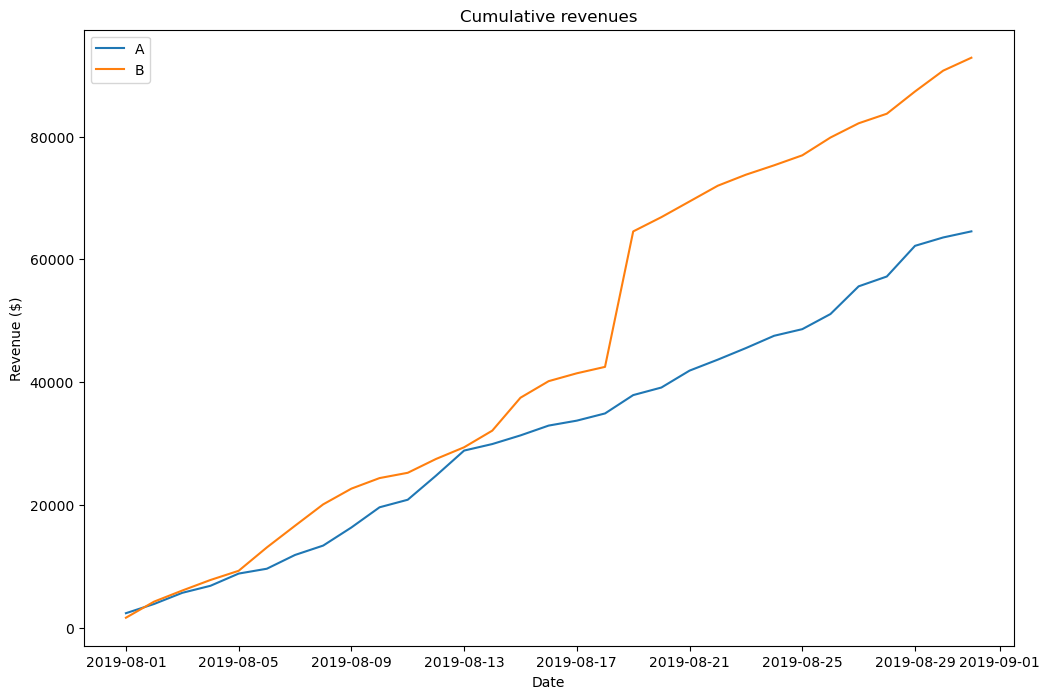

In [11]:
#Filter by group
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#Line plot
plt.figure(figsize=(12,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Cumulative revenues')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

Los ingresos aumentan constantemente durante toda la prueba (buena señal). Se observa también que hubo unas compras grandes aproximadamente el dia 2019-08-19 para el grupo B.

#### 2. Representa gráficamente el tamaño de pedido promedio acumulado por grupo.

Vamos a dividir los ingresos acumulados entre el número acumulado de pedidos:

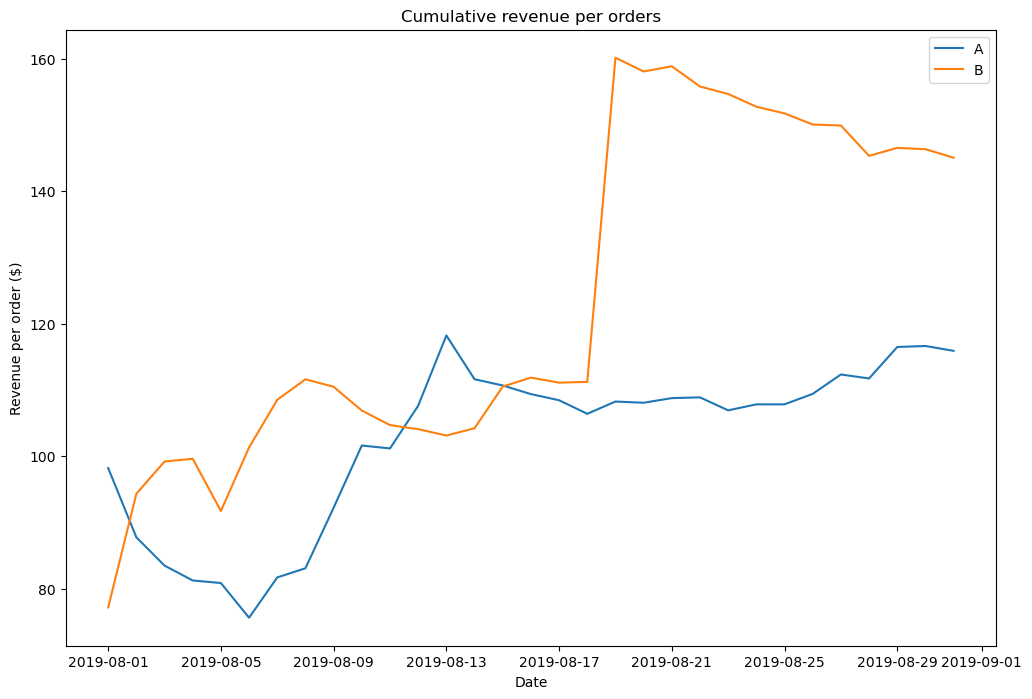

In [12]:
#Line plot
plt.figure(figsize=(12,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Cumulative revenue per orders')
plt.xlabel('Date')
plt.ylabel('Revenue per order ($)')
plt.legend()
plt.show()

Se observa que el tamaño de pedido promedio acumulado (para ambos grupos) iba a ser de 110 dlls/pedido, pero aproximadamente el dia 2019-08-19 hubo una compra muy grande en el grupo B que hizo que el tamaño de pedido promedio acumulado de este grupo creciera demasiado. Después de esa compra el tamaño de compra promedio del grupo B disminuye drásticamente.

#### 3. Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.

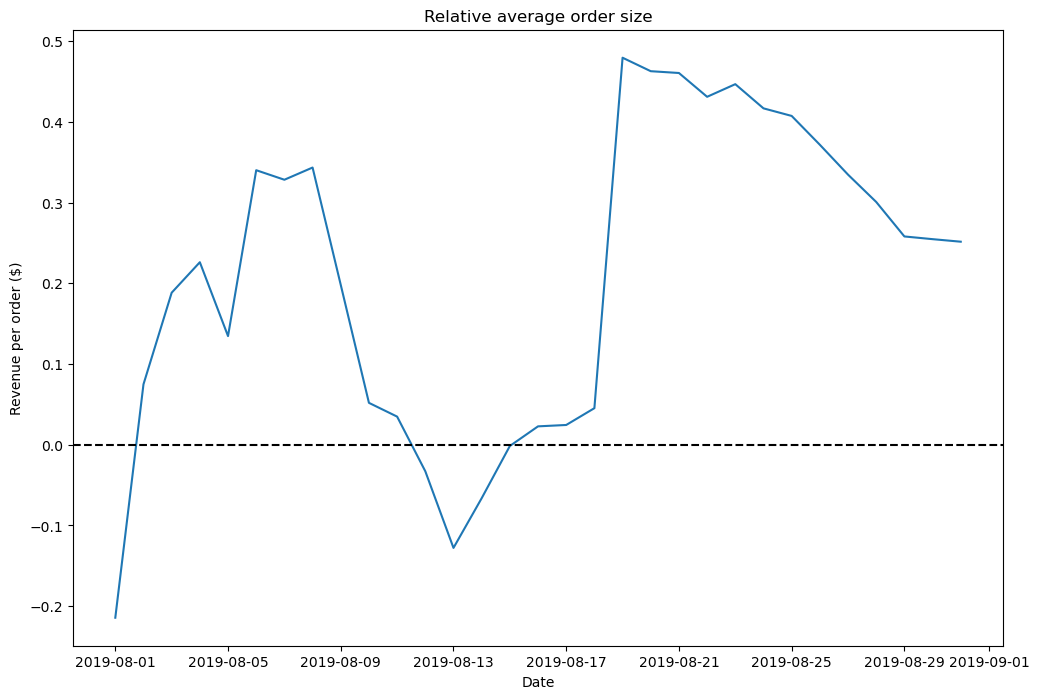

In [13]:
#Merge DataFrames
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12,8))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Relative average order size')
plt.xlabel('Date')
plt.ylabel('Revenue per order ($)')
#plt.legend()
plt.show()

En varios puntos, la diferencia entre los segmentos aumenta, lo que significa que debe haber algunos pedidos grandes y valores atípicos.

#### 4. Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia.

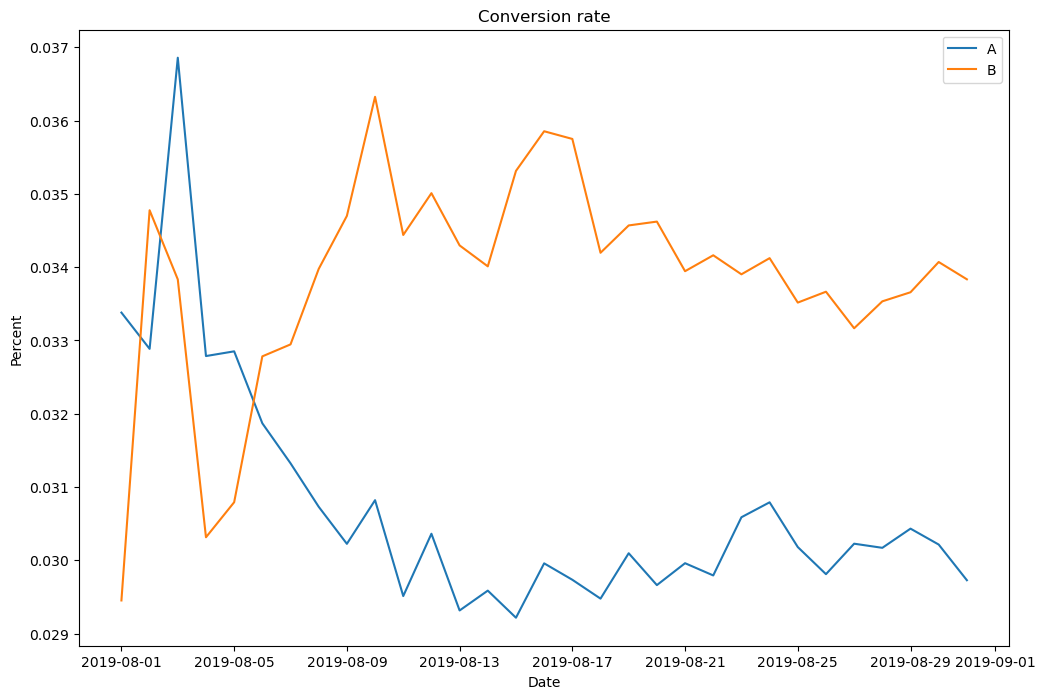

In [14]:
# calcular la conversión acumulada
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# seleccionar datos en el grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# seleccionar datos en el grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# trazar los gráficos
plt.figure(figsize=(12,8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Conversion rate')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.show()

Las tasas de conversión de ambos grupos flutua bastante al principio y en general durante todo el experimento. Aproximadamente despues del dia 2019-08-19, las tasas de conversión se estabilizan a 0.030 para el grupo A y 0.034 para el grupo B.

**Conclusion:** Existen valores atípicos que perturbaron el experimento.

#### 5. Traza un gráfico de dispersión del número de pedidos por usuario.

In [15]:
#Group by 'userId' and count unique values of 'orderId'
ordersByUsers = orders.groupby('userId', as_index=False).agg({'orderId': pd.Series.nunique})
#Change columns names
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.head(3)

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2


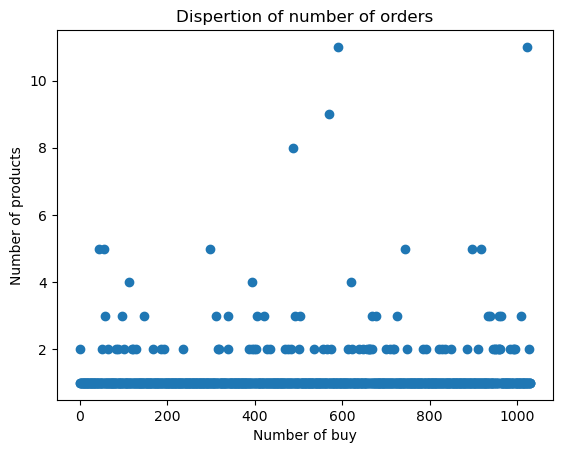

In [16]:
#Scatter plot
x_values = pd.Series(range(0, len(ordersByUsers['orders'])))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('Number of buy')
plt.ylabel('Number of products')
plt.title('Dispertion of number of orders')
plt.show()

Hubo una compras atípicas, en promedio cada usuario compro de 1 a 4 productos.

#### 6. Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [17]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


No más del 5% de los pedidos tienen 2 procdutos y sólo el 1% de los pedidos tienen 4 o más productos por pedido. Una compra de más de 2 productos es una compra anómala.

#### 7. Traza un gráfico de dispersión de los precios de los pedidos.

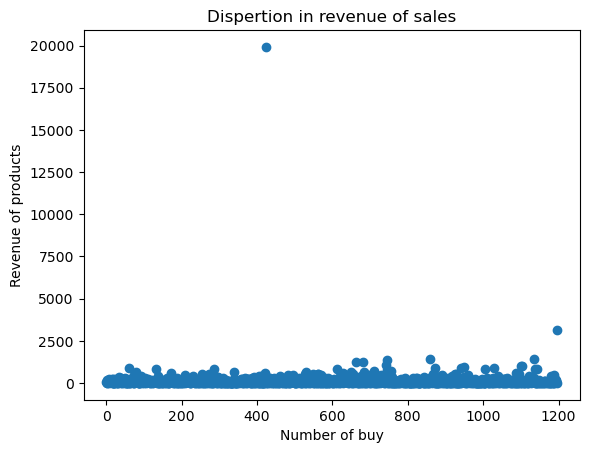

In [18]:
#Scatter plot
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Number of buy')
plt.ylabel('Revenue of products')
plt.title('Dispertion in revenue of sales')
plt.show()

Se puede ver que hubo 2 compras atípicas, de $20000 y 3000, pero puede haber más anomalías en el rango de 1000 a 2500.

#### 8. Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [19]:
print(np.percentile(orders['revenue'], [95, 99]))

[435.54  900.904]


No más del 5% de los pedidos cuestan más de 435 dolares y no más del 1% cuestan más de 900 dolares. Una compra mayor a $435 es una compra anómala.

#### 9. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

Se crearán 2 grupos.

In [20]:
#Group by 'userId' and count unique values of 'orderId' for group A
ordersByUsersA = orders[orders['group']=='A'].groupby('userId', as_index=False).agg({'orderId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

#Group by 'userId' and count unique values of 'orderId' for group B
ordersByUsersB = orders[orders['group']=='B'].groupby('userId', as_index=False).agg({'orderId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

Se crean 2 variables, sampleA y sampleB con usuarios de diferentes grupos y números de pedidos correspondientes. Los que no pidieron nada tendrán un 0. Esto es necesario para preparar las muestras para la prueba de Mann-Whitney.

In [21]:
#Contact 2 series
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
#Contact 2 series
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [22]:
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.138


La significancia estadística de la diferencia en la conversión entre los grupos es 13.8%. Es relativamente grande.

#### 10. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [23]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.252


La significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos es de 25.2%, es relativamente grande, lo que implica hay diferencias entre los grupos.

#### 11. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.

Primero, se deben encontrar los usuarios anómalos.

In [24]:
#Contact 2 DataFrames
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 435.5]['userId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

#Total of abnormal users
print(abnormalUsers.shape[0])

74


In [25]:
#Contact 2 DataFrames
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [26]:
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.173


La significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados es de 17.3%, es relativamente grande, igual que al usar los datos con anomalías.

#### 12. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.

In [27]:
#Obtain average income for group B
incomeB = orders[np.logical_and(orders['group']=='B',np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean()

#Obtain average income for group B
incomeA = orders[np.logical_and(orders['group']=='A',np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean()

#significance
print(incomeB / incomeA -1)

-0.01926809086874892


La significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos es de -1.92%, es baja, lo que implica que no hay diferencias entre los grupos al quitar compras anómalas.

#### 13. Toma una decisión basada en los resultados de la prueba.

Del análisis anterior se mostró que exiten anomalías en las compras, estas anomalías distorcionan bastante los resultados, de manera que se observa una diferencia en el tamaño promedio de pedido entre los grupos A y B del 25.2%. Al quitar estas compras anómalas, la diferencia en el tamaño promedio de pedido entre los grupos es de 1.92%, lo que implica que no hay diferencia significativas entre los grupos.

Al observar las primeas gráficas de este documento (ingresos acumulados, tamaño de pedido promedio acumulado y diferencia relativa del tamaño de pedido promedio acumulado), se observa que el grupo B estuvo por encima del grupo A, en general. De manera que se tomará la decisión de parar la prueba y considerar al grupo B como líder.